<a href="https://colab.research.google.com/github/Gabriel-17ope/An-lise_de_Classifica-o_com_Redes_Convolucionais_e_o_dataset_CUFS.ipynb/blob/main/An%C3%A1lise_de_Classifica%C3%A7%C3%A3o_com_Redes_Convolucionais_e_o_dataset_CUFS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from keras.models import Model
from keras.utils import plot_model

In [2]:
 # Caminho para a pasta com as imagens
path = "/content/drive/MyDrive/Análise_de_Classificação_com_Redes_Convolucionais_e_o_dataset_CUFS/photos"

# Listas para armazenar imagens, rótulos e possíveis erros
images = []
labels = []
failed_images = []

# Processar imagens e rotular
for filename in os.listdir(path):
    file_path = os.path.join(path, filename)

    # Carregar imagem, redimensionar e normalizar
    img = cv2.imread(file_path)
    if img is None:
        print(f"Erro ao carregar a imagem: {file_path}")
        failed_images.append(file_path)
        continue

    img = cv2.resize(img, (200, 250))  # Redimensionar para 250x200
    img = img / 255.0  # Normalizar para o intervalo [0, 1]

    # Adicionar à lista de imagens
    images.append(img)

    # Determinar o rótulo com base no nome do arquivo
    if filename.startswith("f"):  # Feminino
        labels.append(1)
    elif filename.startswith("m"):  # Masculino
        labels.append(0)
    else:
        print(f"Formato de nome inesperado: {filename}")

# Converter para arrays numpy
images = np.array(images, dtype=np.float32)
labels = np.array(labels, dtype=np.int32)

# Verificar distribuição de classes
unique, counts = np.unique(labels, return_counts=True)
print(f"Distribuição de classes: {dict(zip(unique, counts))}")

# Visualizar algumas imagens
for i in range(3):
    plt.imshow(images[i])
    plt.title(f"Label: {'Feminino' if labels[i] == 1 else 'Masculino'}")
    plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Análise_de_Classificação_com_Redes_Convolucionais_e_o_dataset_CUFS/photos'

In [ ]:
# Dividir o dataset
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.5, random_state=23)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.4, random_state=23)

# Transformar os rótulos para one-hot encoding
y_train = to_categorical(y_train, num_classes=2)
y_val = to_categorical(y_val, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

# Construção do modelo CNN com Batch Normalization
from tensorflow.keras.layers import BatchNormalization

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(250, 200, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')  # Duas classes: Masculino e Feminino
])

# Compilar o modelo
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Resumo do modelo
model.summary()

# Validar divisões
print(f"Tamanho do conjunto de treino: {len(X_train)}")
print(f"Tamanho do conjunto de validação: {len(X_val)}")
print(f"Tamanho do conjunto de teste: {len(X_test)}")

In [ ]:
# Compilação do modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Treinamento do modelo
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=15, batch_size=16)

# Visualizar o histórico de treinamento
plt.figure(figsize=(12, 5))

# Perda
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Perda ao longo das épocas')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Acurácia
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia ao longo das épocas')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()

plt.show()

# Avaliação no conjunto de teste
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Teste - Perda: {test_loss:.4f}, Acurácia: {test_accuracy:.4f}")

# Predições no conjunto de teste
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Relatório de classificação
print(classification_report(y_true_classes, y_pred_classes, target_names=['Masculino', 'Feminino']))

# Matriz de confusão
ConfusionMatrixDisplay.from_predictions(y_true_classes, y_pred_classes, display_labels=['Masculino', 'Feminino'])
plt.title('Matriz de Confusão')
plt.show()

# Curva ROC
fpr, tpr, _ = roc_curve(y_true_classes, y_pred[:, 1])  # Usar probabilidades da classe '1'
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('Curva ROC')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.legend()
plt.show()

# Exemplos mal classificados
misclassified_idx = np.where(y_true_classes != y_pred_classes)[0]

for idx in misclassified_idx[:5]:  # Mostrar os 5 primeiros erros
    plt.imshow(X_test[idx])
    plt.title(f"Verdadeiro: {'Feminino' if y_true_classes[idx] == 1 else 'Masculino'} | Predito: {'Feminino' if y_pred_classes[idx] == 1 else 'Masculino'}")
    plt.show()

Epoch 1/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.6087 - loss: 1.9262 - val_accuracy: 0.7500 - val_loss: 0.5727
Epoch 2/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.8008 - loss: 0.5666 - val_accuracy: 0.3929 - val_loss: 0.6895
Epoch 3/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.6149 - loss: 0.6431 - val_accuracy: 0.7500 - val_loss: 0.4544
Epoch 4/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.8182 - loss: 0.4062 - val_accuracy: 0.8571 - val_loss: 0.3882
Epoch 5/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 0.9053 - loss: 0.2773 - val_accuracy: 0.8571 - val_loss: 0.3434
Epoch 6/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.9107 - loss: 0.2408 - val_accuracy: 0.8393 - val_loss: 0.3500
Epoch 7/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.9151 - loss: 0.1957 - val_accuracy: 0.8393 - val_loss: 0.4343
Epoch 8/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 0.9576 - loss: 0.1021 - val_accuracy: 0.9107 - val_loss: 0.3713
Epoch 9/

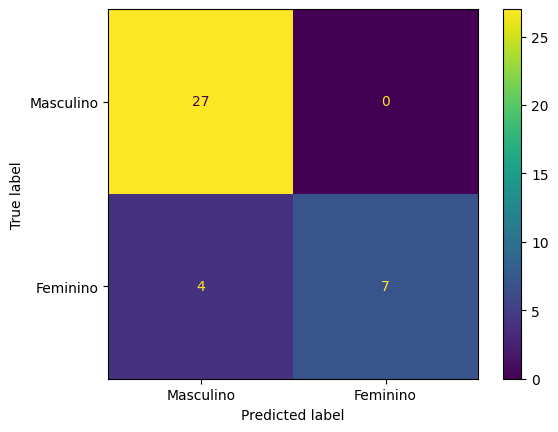

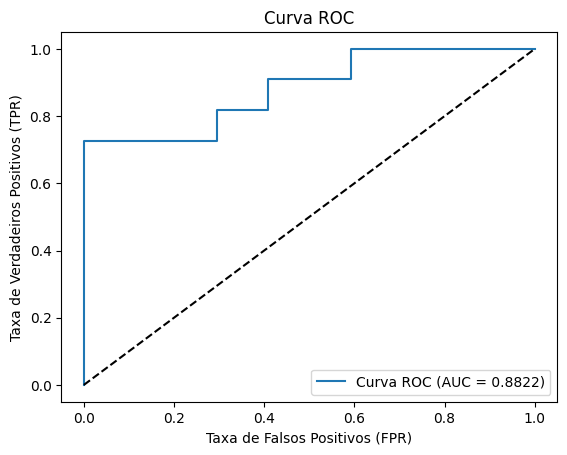

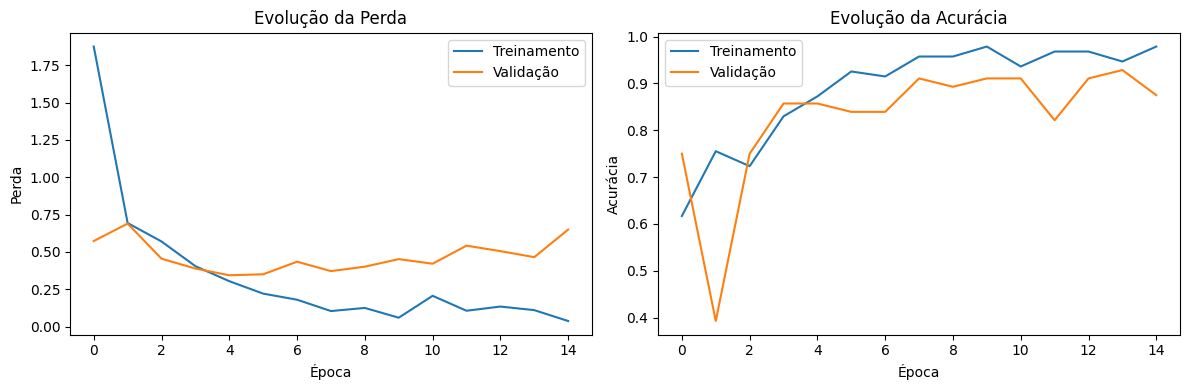

In [ ]:
# Matriz de Confusão
ConfusionMatrixDisplay.from_predictions(
    y_true_classes,
    y_pred_classes,
    display_labels=['Masculino', 'Feminino'],
    cmap='Blues'
)
plt.title('Matriz de Confusão')
plt.xlabel('Classe Predita')
plt.ylabel('Classe Verdadeira')
plt.show()

# Curva ROC
fpr, tpr, _ = roc_curve(y_true_classes, y_pred[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {roc_auc:.4f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)  # Linha diagonal
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

# Gráficos de Treinamento
plt.figure(figsize=(12, 4))

# Perda
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], '-o', label='Treinamento')
plt.plot(history.history['val_loss'], '-o', label='Validação')
plt.title('Evolução da Perda')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()
plt.grid(alpha=0.3)

# Acurácia
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], '-o', label='Treinamento')
plt.plot(history.history['val_accuracy'], '-o', label='Validação')
plt.title('Evolução da Acurácia')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()